# Data profiling

In [2]:
import pandas as pd
import numpy as np
from support_functions import log_progress, clean_drugbank, query_chembl
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import functools
from cmapPy.pandasGEXpress import parse
import scipy
%load_ext line_profiler
import time

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## 0. Lookup known targets

In [77]:
# load perturbation info
pert_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_pert_info.txt', sep='\t', header=0)
pert_info_2a = pd.read_csv('data/GSE70138_Broad_LINCS_pert_info.txt', sep='\t', header=0)
all_pert_info = pd.concat([pert_info_1, pert_info_2a], ignore_index=True)

In [78]:
# lookup cpd inchi keys
all_cpd_pert_info = all_pert_info[all_pert_info.pert_type == 'trt_cp']
all_cpd_inchis = all_cpd_pert_info[['pert_id','inchi_key']].set_index('pert_id').copy()
# remove duplicates, store as series
all_cpd_inchis = all_cpd_inchis[~all_cpd_inchis.index.duplicated()].inchi_key

### 0a. Lookup Drugbank targets

In [5]:
# lookup and store drugbank targets as dictionary: { inchi: [targets]}
db_db_path = 'data/full_drugbank_database.xml'
drugbank_target_dict = clean_drugbank(db_db_path)

KeyboardInterrupt: 

In [ ]:
# save to file
filename = 'checkpoint_files/drugbank_target_dict.sav'
pickle.dump(drugbank_target_dict, open(filename, 'wb'))

### 0b. Lookup Chembl targets

In [ ]:
# lookup and store chembl targets as dictionary: { inchi: [targets]}
chembl_target_dict = {}
tested_inchis = [] # b/c this bitch keeps crashing

In [ ]:
# query CHEMBL API using cpd inchi_keys to find human targets
for inchi in log_progress(all_cpd_inchis.values, every=2):
    if inchi not in tested_inchis:
        human_target_genes = query_chembl(inchi)
        if len(human_target_genes) > 0:
            chembl_target_dict[inchi] = human_target_genes
        tested_inchis.append(inchi)

In [ ]:
# save to file
filename = 'checkpoint_files/chembl_target_dict.sav'
pickle.dump(chembl_target_dict, open(filename, 'wb'))

### 0c. Combine targets

In [79]:
drugbank_target_dict = pickle.load(open('checkpoint_files/drugbank_target_dict.sav', 'rb'))
chembl_target_dict = pickle.load(open('checkpoint_files/chembl_target_dict.sav', 'rb'))

combined_target_dict = drugbank_target_dict.copy()
for cpd, chembl_targets in log_progress(chembl_target_dict.items()):
    try:
        drugbank_targets = drugbank_target_dict[cpd]
        combined_targets = list(set().union(chembl_targets,drugbank_targets))
        combined_target_dict[cpd] = combined_targets
    except KeyError:
        combined_target_dict[cpd] = chembl_targets

## 1. Identify cpd-KD pairs (pair set 1)

The first of several filtering steps, this set is composed of pairs of known cpd-target interactions where both the cpd and the target KD have been tested in at least one LINCS experiment.

In [80]:
all_kd_pert_info = all_pert_info[all_pert_info.pert_type == 'trt_sh']
kd_genes = all_kd_pert_info.pert_iname.unique()
len(kd_genes)

4371

In [83]:
cpd_1_, target_1_, label_1_ = [], [], []
for index, row in log_progress(all_cpd_pert_info.iterrows(), every=1000):
    inchi = row.inchi_key
    
    # if the cpd has targets
    if inchi in combined_target_dict.keys():
        pert_id = row.pert_id
        targets = combined_target_dict[inchi]
        
        # add targets as positive examples
        for target in targets:
            if target in kd_genes:
                cpd_1_.append(pert_id)
                target_1_.append(target)
                label_1_.append(1)
                
        # add non-targets as negative examples
        for gene in kd_genes:
            if gene not in targets:
                cpd_1_.append(pert_id)
                target_1_.append(gene)
                label_1_.append(0)
                
    # if the compound has no targets
    else:
        pert_id = row.pert_id
        for gene in kd_genes:
            cpd_1_.append(pert_id)
            target_1_.append(gene)
            label_1_.append(0)

In [84]:
pair_set_1_df = pd.DataFrame({'cpd': cpd_1_, 'target': target_1_, 'label': label_1_})
pair_set_1_df.to_csv('checkpoint_files/pair_set_1_df.csv')

In [85]:
pair_set_1_df = pd.DataFrame.from_csv('checkpoint_files/pair_set_1_df.csv')

print('Pair set 1 statistics\n')
print('No. True interactions:\t', pair_set_1_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_1_df[pair_set_1_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_1_df[pair_set_1_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_1_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_1_df[pair_set_1_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_1_df[pair_set_1_df.label == 0].target.unique()))

Pair set 1 statistics

No. True interactions:	 4220
No. True cpds:		 1076
No. True genes:		 624

No. False interactions:	 97071332
No. False cpds:		 21299
No. False genes:	 4371


## 2. Identify same-cell cpd-KD pairs (pair set 2)

The second of several filtering steps, here we filter out cpd-KD pairs that have not both been tested in at least one common cell line.

### 2a. Signature quality filter

This step of finding common cells for all 100 million potential cpd-kd pairs is very slow. To speed things up we'll apply the signature quality filter here, rather than later on in the pipeline. We'll also store the high-quality signatures in dictionaries so that we can look them up quickly.

In [8]:
# load the signature information
all_sig_info = pd.DataFrame.from_csv('checkpoint_files/all_sig_info.csv')
all_cpd_sig_info = all_sig_info[all_sig_info.pert_type == 'trt_cp'].copy()
all_kd_sig_info = all_sig_info[all_sig_info.pert_type == 'trt_sh'].copy()

/Users/Nico/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2850: DtypeWarning: Columns (4,6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [12]:
# data quality parameters 
pct_self_rank_cutoff = 0.05
distill_cc_cutoff = 0.2

# filter the data
good_cpd_sig_info = all_cpd_sig_info[(all_cpd_sig_info.distil_cc_q75 >= distill_cc_cutoff) &
                                     (all_cpd_sig_info.pct_self_rank_q25 <= pct_self_rank_cutoff)].copy()
good_kd_sig_info = all_kd_sig_info[(all_kd_sig_info.distil_cc_q75 >= distill_cc_cutoff) &
                                   (all_kd_sig_info.pct_self_rank_q25 <= pct_self_rank_cutoff)].copy()

In [13]:
# create a dictionary of the good signatures so we can 
# look them up quickly by cpd/kd
good_cpds = set(good_cpd_sig_info.pert_id.unique())
good_cpd_sig_info_dict = {}
for cpd in log_progress(good_cpds):
    good_cpd_sig_info_dict[cpd] = good_cpd_sig_info[good_cpd_sig_info.pert_id == cpd].copy()
    
good_kds = set(good_kd_sig_info.pert_iname.unique())
good_kd_sig_info_dict = {}
for kd in log_progress(good_kds):
    good_kd_sig_info_dict[kd] = good_kd_sig_info[good_kd_sig_info.pert_iname == kd].copy()

In [14]:
# select representative sigs for good cpds
repr_cpd_sig_info_dict = {}
for cpd, good_sig_df in log_progress(good_cpd_sig_info_dict.items()):
    repr_cpd_sigs_df = pd.DataFrame(columns=good_sig_df.columns)
    for cell_line in good_sig_df.cell_id.unique():
        candidate_sigs = good_sig_df[good_sig_df.cell_id == cell_line]
        repr_sig = candidate_sigs.loc[candidate_sigs['tas'].idxmax()].copy()
        repr_cpd_sigs_df = repr_cpd_sigs_df.append(repr_sig)
    repr_cpd_sig_info_dict[cpd] = repr_cpd_sigs_df

# select representative kd sigs for good kds
repr_kd_sig_info_dict = {}
for kd, good_sig_df in log_progress(good_kd_sig_info_dict.items()):
    repr_kd_sigs_df = pd.DataFrame(columns=good_sig_df.columns)
    for cell_line in good_sig_df.cell_id.unique():
        candidate_sigs = good_sig_df[good_sig_df.cell_id == cell_line]
        repr_sig = candidate_sigs.loc[candidate_sigs['tas'].idxmax()].copy()
        repr_kd_sigs_df = repr_kd_sigs_df.append(repr_sig)
    repr_kd_sig_info_dict[kd] = repr_kd_sigs_df

In [15]:
# save the data
pickle.dump(good_cpds, open('checkpoint_files/good_cpds.sav', 'wb'))
pickle.dump(good_kds, open('checkpoint_files/good_kds.sav', 'wb'))
pickle.dump(repr_cpd_sig_info_dict, open('checkpoint_files/repr_cpd_sig_info_dict.sav', 'wb'))
pickle.dump(repr_kd_sig_info_dict, open('checkpoint_files/repr_kd_sig_info_dict.sav', 'wb'))

In [3]:
# load the data
good_cpds = pickle.load(open('checkpoint_files/good_cpds.sav', 'rb'))
good_kds = pickle.load(open('checkpoint_files/good_kds.sav', 'rb'))
repr_cpd_sig_info_dict = pickle.load(open('checkpoint_files/repr_cpd_sig_info_dict.sav', 'rb'))
repr_kd_sig_info_dict = pickle.load(open('checkpoint_files/repr_kd_sig_info_dict.sav', 'rb'))

### 2b. Identify pairs w/ high quality sigs (both cpd and kd)

In [92]:
cpd_2_, target_2_, label_2_, common_cells_2_ = [], [], [], []

for index, row in log_progress(pair_set_1_df.iterrows(), every=5000):

    # bookmark to (hopfeully) save time
    curr_cpd = ''
    curr_cpd_sigs_df = ''
    curr_cpd_cells = ''
    
    # extract signatures
    cpd = row.cpd
    if cpd in good_cpds:
        target = row.target
        if target in good_kds: 
            
            # check if we need to load data for new cpd
            if not cpd == curr_cpd:
                curr_cpd = cpd
                curr_cpd_sigs_df = repr_cpd_sig_info_dict[curr_cpd]
                curr_cpd_cells = set(curr_cpd_sigs_df.cell_id.unique())
            
            # load data for target
            kd_sigs = repr_kd_sig_info_dict[target]
            kd_cells = set(kd_sigs.cell_id.unique())
            
            # compare cell lines
            common_cells = curr_cpd_cells & kd_cells
            if len(common_cells) > 0:
                cpd_2_.append(cpd)
                target_2_.append(target)
                label_2_.append(row.label)
                common_cells_2_.append(common_cells)

In [93]:
pair_set_2_df = pd.DataFrame({'cpd': cpd_2_, 'target': target_2_, 'label': label_2_})
pair_set_2_df.to_csv('checkpoint_files/pair_set_2_df.csv')
pickle.dump(common_cells_2_, open('checkpoint_files/common_cells_2_.sav', 'wb'))

In [4]:
pair_set_2_df = pd.DataFrame.from_csv('checkpoint_files/pair_set_2_df.csv')
common_cells_2_ = pickle.load(open('checkpoint_files/common_cells_2_.sav', 'rb'))

In [5]:
print('Pair set 2 statistics\n')
print('No. True interactions:\t', pair_set_2_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_2_df[pair_set_2_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_2_df[pair_set_2_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_2_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_2_df[pair_set_2_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_2_df[pair_set_2_df.label == 0].target.unique()))

Pair set 2 statistics

No. True interactions:	 2827
No. True cpds:		 636
No. True genes:		 469

No. False interactions:	 18171209
No. False cpds:		 4240
No. False genes:	 4344


## 3. Identify cpd-KD pairs with interaction partner KDs (pair set 3)

The third of several filtering steps, here we filter out cpd-KD pairs for which we do not know any interaction partners for the target.

In [6]:
# load STRING 4.0 database
# 355319.0 high confidence interactions for 14893 genes
string_gene_interactions_700 = pd.DataFrame.from_csv('checkpoint_files/string_gene_interactions_700.csv')
string_genes = set(string_gene_interactions_700.gene_1.unique())

In [10]:
# convert string interactions to dictionary of sets for fast lookup
string_interactions_dict = {}
for gene in log_progress(string_genes, every=10):
    partners = string_gene_interactions_700[string_gene_interactions_700.gene_1 == gene].gene_2
    partner_set = set(partners)
    string_interactions_dict[gene] = partner_set

In [11]:
# save the interactions
pickle.dump(string_interactions_dict, open('checkpoint_files/string_interactions_dict.sav', 'wb'))

In [4]:
# load the interactions
string_interactions_dict = pickle.load(open('checkpoint_files/string_interactions_dict.sav', 'rb'))

In [14]:
cpd_3_, target_3_, label_3_, common_cells_3_ = [], [], [], []
targets_without_partner_kds = []

for index, row in log_progress(pair_set_2_df.iterrows(), every=5000):
    target = row.target
    # check if there are interaction partners
    if target in string_genes:
        partners = string_interactions_dict[target]
        # check if partners have KDS
        partner_kds = partners.intersection(good_kds)   
        if len(partner_kds) > 0:
            cpd_3_.append(row.cpd)
            target_3_.append(target)
            label_3_.append(row.label)
            common_cells_3_.append(common_cells_2_[index])
        else:
            targets_without_partner_kds.append(target)

In [15]:
pair_set_3_df = pd.DataFrame({'cpd': cpd_3_, 'target': target_3_, 'label': label_3_})
pair_set_3_df.to_csv('checkpoint_files/pair_set_3_df.csv')
pickle.dump(common_cells_3_, open('checkpoint_files/common_cells_3_.sav', 'wb'))

In [129]:
pair_set_3_df = pd.DataFrame.from_csv('checkpoint_files/pair_set_3_df.csv')
common_cells_3_ = pickle.load(open('checkpoint_files/common_cells_3_.sav', 'rb'))

In [16]:
print('Pair set 3 statistics\n')
print('No. True interactions:\t', pair_set_3_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_3_df[pair_set_3_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_3_df[pair_set_3_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_3_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_3_df[pair_set_3_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_3_df[pair_set_3_df.label == 0].target.unique()))

Pair set 3 statistics

No. True interactions:	 2789
No. True cpds:		 634
No. True genes:		 455

No. False interactions:	 15528727
No. False cpds:		 4240
No. False genes:	 3668


# 4. Discard pairs not tested in at least 3 different cell lines. (pair set 4)

In [14]:
min_num_cells = 3

In [17]:
cpd_4_, target_4_, label_4_, common_cells_4_ = [], [], [], [],

for index, row in log_progress(pair_set_3_df.iterrows(), every=5000):
    common_cells = common_cells_3_[index]
    if len(common_cells) >= min_num_cells:
        cpd_4_.append(row.cpd)
        target_4_.append(row.target)
        label_4_.append(row.label)
        common_cells_4_.append(common_cells)

In [18]:
pair_set_4_df = pd.DataFrame({'cpd': cpd_4_, 'target': target_4_, 'label': label_4_})

In [19]:
pair_set_4_df.to_csv('checkpoint_files/pair_set_4_df.csv')
pickle.dump(common_cells_4_, open('checkpoint_files/common_cells_4_.sav', 'wb'))

In [4]:
pair_set_4_df = pd.DataFrame.from_csv('checkpoint_files/pair_set_4_df.csv')
common_cells_4_ = pickle.load(open('checkpoint_files/common_cells_4_.sav', 'rb'))

In [20]:
print('Pair set 4 statistics\n')
print('No. True interactions:\t', pair_set_4_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_4_df[pair_set_4_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_4_df[pair_set_4_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_4_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_4_df[pair_set_4_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_4_df[pair_set_4_df.label == 0].target.unique()))

Pair set 4 statistics

No. True interactions:	 1310
No. True cpds:		 232
No. True genes:		 303

No. False interactions:	 4498567
No. False cpds:		 1228
No. False genes:	 3320


## 5. Identify cpd-KD pairs with same-cell interaction partner KDs (pair set 5)

The fourth of several filtering steps, here we filter out cpd-KD pairs for which the target's interaction partners were not knocked down in any of the same cells as the cpd-target pair.

Because this step takes SO long we're going to break up our dataframe into chunks and then run run the filter in parallel.

In [11]:
import multiprocessing
num_processes = 6 #multiprocessing.cpu_count()

In [12]:
def filter_pairs(input_stuff):
    pair_df, common_cells_ = input_stuff
    cpd_5_, target_5_, label_5_, common_cells_5_, common_partners_5_ = [], [], [], [], []
    
    for index, row in pair_df.iterrows(): 
        
        if index % 10000 == 0: print(index)
        
        common_cells = common_cells_[index]
        target = row.target
        common_partners_dict = {}

        # find interaction partner signatures
        partners = string_interactions_dict[target]
        partner_kds = partners.intersection(good_kds)
        partner_sigs = pd.concat([ repr_kd_sig_info_dict[p] for p in partner_kds ], ignore_index=True)
        # group partner sigs by cell line
        for cell_line in common_cells:
            partner_cell_sigs = partner_sigs[partner_sigs.cell_id == cell_line]
            
            if not partner_cell_sigs.empty:
                cell_partners = set(partner_cell_sigs.pert_iname.unique())
                common_partners_dict[cell_line] = cell_partners

        # make sure we have partner KDs in at least three cell lines,
        # since we're only considering pairs with this minimum amount of data
        if len(common_partners_dict.keys()) >= min_num_cells:
            common_cells_5 = set(common_partners_dict.keys())
            cpd_5_.append(row.cpd)
            target_5_.append(target)
            label_5_.append(row.label)
            common_cells_5_.append(common_cells_5)
            common_partners_5_.append(common_partners_dict)
            
    return cpd_5_, target_5_, label_5_, common_cells_5_, common_partners_5_

In [13]:
# break the pairs up into batches
num_batches = 10
batch_size = 450000 # len(pair_set_4_df) / num_batches = 449987.7
pdf4_batches = [ pair_set_4_df.iloc[pair_set_4_df.index[i:i + batch_size]].reset_index(drop=True)for i in range(0,num_batches*batch_size,batch_size) ]
common_cell_batches = [ common_cells_4_[i:i + batch_size] for i in range(0,num_batches*batch_size,batch_size) ]

In [14]:
# run the filter on each batch of the data
for j in range(10):
    
    print('STARTING BATCH: ', j)
    # reset memory
    cpd_5_, target_5_, label_5_, common_cells_5_, common_partners_5_, pair_set_5_df = [None]*6
    result = None
    cpd_5_t, target_5_t, label_5_t, common_cells_5_t, common_partners_5_t = [None]*5

    # get data
    pdf4_batch = pdf4_batches[j]
    cc_batch = common_cell_batches[j]

    # calculate the chunk size as an integer
    chunk_size = int(pdf4_batch.shape[0]/num_processes)

    # break the dataframe up into chunks
    pair_chunks = [ pdf4_batch.iloc[pdf4_batch.index[i:i + chunk_size]].reset_index(drop=True) for i in range(0, pdf4_batch.shape[0], chunk_size)]
    cell_chunks = [ cc_batch[i:i + chunk_size] for i in range(0, len(cc_batch), chunk_size) ]
    chunks = list(zip(pair_chunks, cell_chunks))

    # filter each section of the pairs dataframe in parallel
    cpd_5_, target_5_, label_5_, common_cells_5_, common_partners_5_ = [], [], [], [], []
    pool = multiprocessing.Pool(processes=num_processes)
    result = pool.map(filter_pairs, chunks)
    pool.close()

    cpd_5_t, target_5_t, label_5_t, common_cells_5_t, common_partners_5_t = zip(*result)
    cpd_5_ = functools.reduce( lambda x,y: x+y, [ c for c in list(cpd_5_t) ] )
    target_5_ = functools.reduce( lambda x,y: x+y, [ t for t in list(target_5_t) ] )
    label_5_ = functools.reduce( lambda x,y: x+y, [ l for l in list(label_5_t) ] )
    common_cells_5_ = functools.reduce( lambda x,y: x+y, [ cc for cc in list(common_cells_5_t) ] )
    common_partners_5_ = functools.reduce( lambda x,y: x+y, [ cc for cc in list(common_partners_5_t) ] )

    print('\nMAKING DATAFRAME')
    pair_set_5_df = pd.DataFrame({'cpd': cpd_5_, 'target': target_5_, 'label': label_5_})

    print('\nSAVING DATAFRAME')
    df_filename = 'checkpoint_files/pair_set_5_df_{}.csv'.format(j)
    pair_set_5_df.to_csv(df_filename)

    print('\nSAVING COMMON CELLS')
    cc_filename = 'checkpoint_files/common_cells_5_{}.sav'.format(j)
    cc_file = open(cc_filename, 'wb')
    pickle.dump(common_cells_5_, cc_file)
    cc_file.close()

    print('\nSAVING COMMON PARTNERS')
    cp_filename = 'checkpoint_files/common_partners_5_{}.sav'.format(j)
    cp_file = open(cp_filename, 'wb')
    pickle.dump(common_partners_5_, cp_file)
    cp_file.close()

    print('\nDONE')

STARTING BATCH:  0
0
0
0
0
0
0
10000
10000
10000
10000
10000
10000
20000
20000
20000
20000
20000
20000
30000
30000
30000
30000
30000
30000
40000
40000
40000
40000
40000
40000
50000
50000
50000
50000
50000
50000
60000
60000
60000
60000
60000
60000
70000
70000
70000
70000
70000
70000

MAKING DATAFRAME

SAVING DATAFRAME

SAVING COMMON CELLS

SAVING COMMON PARTNERS

DONE
STARTING BATCH:  1
0
0
0
0
0
0
10000
10000
10000
10000
10000
10000
20000
20000
20000
20000
20000
20000
30000
30000
30000
30000
30000
30000
40000
40000
40000
40000
40000
40000
50000
50000
50000
50000
50000
50000
60000
60000
60000
60000
60000
60000
70000
70000
70000
70000
70000
70000

MAKING DATAFRAME

SAVING DATAFRAME

SAVING COMMON CELLS

SAVING COMMON PARTNERS

DONE
STARTING BATCH:  2
0
0
0
0
0
0
10000
10000
10000
10000
10000
10000
20000
20000
20000
20000
20000
20000
30000
30000
30000
30000
30000
30000
40000
40000
40000
40000
40000
40000
50000
50000
50000
50000
50000
50000
60000
60000
60000
60000
60000
60000
70000
70000
7

In [15]:
# LOAD DATA AND put the pieces back together
pair_set_5_df = pd.DataFrame(columns=pair_set_4_df.columns)
common_cells_5_ = []
common_partners_5_ = []

for j in log_progress(range(10)):
    df_filename = 'checkpoint_files/pair_set_5_df_{}.csv'.format(j)
    cc_filename = 'checkpoint_files/common_cells_5_{}.sav'.format(j)
    cp_filename = 'checkpoint_files/common_partners_5_{}.sav'.format(j)
    
    pair_set_5_df = pair_set_5_df.append(pd.DataFrame.from_csv(df_filename))
    common_cells_5_ += pickle.load(open(cc_filename, 'rb'))
    #common_partners_5_ += pickle.load(open(cp_filename, 'rb'))

In [8]:
print('Pair set 5 statistics\n')
print('No. True interactions:\t', pair_set_5_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_5_df[pair_set_5_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_5_df[pair_set_5_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_5_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_5_df[pair_set_5_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_5_df[pair_set_5_df.label == 0].target.unique()))

Pair set 5 statistics

No. True interactions:	 1308
No. True cpds:		 232
No. True genes:		 302

No. False interactions:	 4429884
No. False cpds:		 1228
No. False genes:	 3288


## Cell count anaylsis
Which cell lines are are true interactions happening in?

In [16]:
true_pair_idx = pair_set_5_df[pair_set_5_df.label == 1].index.values.astype(int)
true_pair_common_cells = np.array(common_cells_5_)[true_pair_idx]

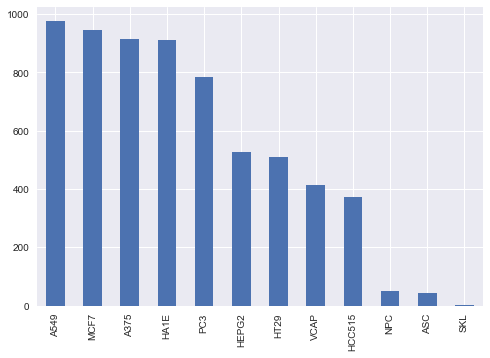

In [17]:
# which cell lines are most common?
all_cell_list = np.array(functools.reduce( lambda x,y: x+y, [ list(s) for s in true_pair_common_cells ] ))
cell_line_counts = pd.Series(all_cell_list).value_counts()
cell_line_counts.plot.bar()
plt.show()

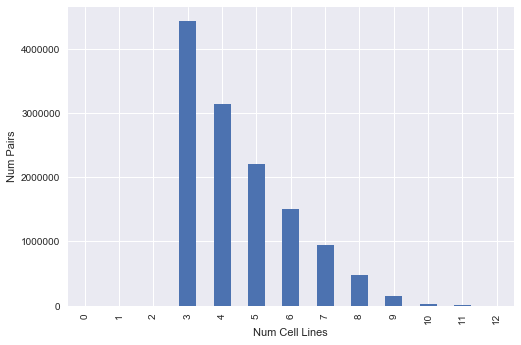

In [18]:
# how many pairs tested in at least n cell lines?
num_common_cells_5 = np.array([ len(cells) for cells in common_cells_5_])
pair_set_5_df['ncells'] = num_common_cells_5
ncell_counts = pair_set_5_df.ncells.value_counts()
cum_ncell_counts = [0,0,0]
for i in ncell_counts.index:
    cum_ncell_counts.append(sum(ncell_counts.loc[i:]))
cum_ncell_counts = pd.Series(cum_ncell_counts)
cum_ncell_counts.plot.bar()
plt.ylabel('Num Pairs')
plt.xlabel('Num Cell Lines')
plt.show()

## 6. Most common cell lines (pair set 6)
Three of the cell lines have very few drugs. We can ignore them and just focus on data from the 9 most common cell lines. 

**This also has to be done in batches**

In [19]:
top_9_cell_lines = set(cell_line_counts.index[:9])

In [18]:
# filter out pairs not in the top-9 cell lines

for j in range(10):
    print('BATCH {}'.format(j))
    cpd_6_, target_6_, label_6_, common_cells_6_, common_partners_6_ = [], [], [], [], []
    
    print('LOADING DATA')
    df_filename = 'checkpoint_files/pair_set_5_df_{}.csv'.format(j)
    cc_filename = 'checkpoint_files/common_cells_5_{}.sav'.format(j)
    cp_filename = 'checkpoint_files/common_partners_5_{}.sav'.format(j)
    
    p_5_df = pd.DataFrame.from_csv(df_filename)
    
    cc_5_file = open(cc_filename, 'rb')
    cc_5_ = pickle.load(cc_5_file)
    cc_5_file.close()
    
    cp_5_file = open(cp_filename, 'rb')
    cp_5_ = pickle.load(cp_5_file)
    cp_5_file.close()
    
    print('FILTERING DATA')
    for index, row in log_progress(p_5_df.iterrows(), every=5000):
        common_cells = cc_5_[index]
        top_common_cells = common_cells & top_9_cell_lines
        if len(top_common_cells) >= min_num_cells:
            cpd_6_.append(row.cpd)
            target_6_.append(row.target)
            label_6_.append(row.label)
            common_cells_6_.append(top_common_cells)

            common_partners = {}
            for c in top_common_cells:
                common_partners[c] = cp_5_[index][c]
            common_partners_6_.append(common_partners)
            
    print('MAKING DATAFRAME')
    pair_set_6_df = pd.DataFrame({'cpd': cpd_6_, 'target': target_6_, 'label': label_6_})

    print('SAVING DATAFRAME')
    df_filename = 'checkpoint_files/pair_set_6_df_{}.csv'.format(j)
    pair_set_6_df.to_csv(df_filename)

    print('SAVING COMMON CELLS')
    cc_filename = 'checkpoint_files/common_cells_6_{}.sav'.format(j)
    cc_file = open(cc_filename, 'wb')
    pickle.dump(common_cells_6_, cc_file)
    cc_file.close()

    print('SAVING COMMON PARTNERS')
    cp_filename = 'checkpoint_files/common_partners_6_{}.sav'.format(j)
    cp_file = open(cp_filename, 'wb')
    pickle.dump(common_partners_6_, cp_file)
    cp_file.close()

    print('RESETTING MEMORY')
    cpd_6_, target_6_, label_6_, common_cells_6_, common_partners_6_ = None, None, None, None, None
    p_5_df, cc_5_, cp_5_ = None, None, None
    
    
    print('DONE\n')

BATCH 0
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 1
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 2
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 3
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 4
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 5
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 6
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 7
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 8
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE

BATCH 9
LOADING DATA
FILTERING DATA


MAKING DATAFRAME
SAVING DATAFRAME
SAVING COMMON CELLS
SAVING COMMON PARTNERS
RESETTING MEMORY
DONE



In [27]:
# LOAD DATA AND put the pieces back together
pair_set_6_df = pd.DataFrame(columns=['cpd', 'label', 'target'])
common_cells_6_ = []
common_partners_6_ = []

for j in log_progress(range(10)):
    df_filename = 'checkpoint_files/pair_set_6_df_{}.csv'.format(j)
    cc_filename = 'checkpoint_files/common_cells_6_{}.sav'.format(j)
    cp_filename = 'checkpoint_files/common_partners_6_{}.sav'.format(j)
    
    pair_set_6_df = pair_set_6_df.append(pd.DataFrame.from_csv(df_filename))
    #common_cells_6_ += pickle.load(open(cc_filename, 'rb'))
    #common_partners_5_ += pickle.load(open(cp_filename, 'rb'))

In [20]:
print('Pair set 6 statistics\n')
print('No. True interactions:\t', pair_set_6_df.label.value_counts()[1])
print('No. True cpds:\t\t', len(pair_set_6_df[pair_set_6_df.label == 1].cpd.unique()))
print('No. True genes:\t\t', len(pair_set_6_df[pair_set_6_df.label == 1].target.unique()))
print('\nNo. False interactions:\t', pair_set_6_df.label.value_counts()[0])
print('No. False cpds:\t\t', len(pair_set_6_df[pair_set_6_df.label == 0].cpd.unique()))
print('No. False genes:\t', len(pair_set_6_df[pair_set_6_df.label == 0].target.unique()))

Pair set 6 statistics

No. True interactions:	 1303
No. True cpds:		 229
No. True genes:		 302

No. False interactions:	 4394682
No. False cpds:		 1180
No. False genes:	 3245


___
# Extract gene expression signatures

### Compounds

In [165]:
# load filtered data
pair_set_6_df = pickle.load(open('checkpoint_files/pair_set_6_df.sav', 'rb'))
common_cells_6_ = pickle.load(open('checkpoint_files/common_cells_6_.sav', 'rb'))
#common_partners_6_ = pickle.load(open('checkpoint_files/common_partners_7_', 'rb'))

In [6]:
# reference lists
top_9_cell_line_cpds = pair_set_6_df.cpd.unique()
top_9_cell_line_kds = pair_set_6_df.target.unique()

gene_info_1 = pd.read_csv('data/GSE92742_Broad_LINCS_gene_info.txt', sep='\t', header=0)
lm_genes = gene_info_1[gene_info_1['pr_is_lm'].astype(bool)]
lm_gene_ids = lm_genes['pr_gene_id'].astype(str).values

In [20]:
# select representatives
repr_top_9_cpd_sigs = pd.DataFrame(columns=all_cpd_sig_info.columns)
for pert_id in log_progress(top_9_cell_line_cpds):
    repr_cpd_sigs = repr_cpd_sig_info_dict[pert_id]
    repr_cpd_sigs = repr_cpd_sigs[repr_cpd_sigs.cell_id.isin(top_9_cell_lines)]
    repr_top_9_cpd_sigs = repr_top_9_cpd_sigs.append(repr_cpd_sigs)

In [21]:
# extract the actual signatures
phase_1_sig_ids = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', col_meta_only=True).index.values
phase_2_sig_ids = parse('data/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx', col_meta_only=True).index.values

# The GCTX files encode the sig IDS as strings of byte strings (why????) so we have to deal with that
top_9_cpd_sig_ids = [ str(s.encode('UTF8')) for s  in repr_top_9_cpd_sigs.sig_id.values ]
phase_1_top_9_cpd_sig_ids = [ s for s in top_9_cpd_sig_ids if s in phase_1_sig_ids ]
phase_2_top_9_cpd_sig_ids = [ s for s in top_9_cpd_sig_ids if s in phase_2_sig_ids ]

# extract the actual signatures
phase_1_top_9_cpd_sigs = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', cid=phase_1_top_9_cpd_sig_ids).data_df
phase_2_top_9_cpd_sigs = parse('data/GSE70138_Broad_LINCS_Level5_COMPZ_n118050x12328_2017-03-06.gctx', cid=phase_2_top_9_cpd_sig_ids).data_df
phase_2_top_9_cpd_sigs.rename(lambda x: x[2:-1], inplace=True)
top_9_cpd_raw_sigs = pd.concat([phase_1_top_9_cpd_sigs, phase_2_top_9_cpd_sigs], axis=1)

# discard all but landmark gene values
top_9_cpd_lm_sigs = top_9_cpd_raw_sigs[top_9_cpd_raw_sigs.index.isin(lm_gene_ids)].sort_index().copy()

# reformat the sig_ids so they are nice strings
top_9_cpd_lm_sigs = top_9_cpd_lm_sigs.T.rename(lambda x: x.lstrip('b\'').rstrip('\'')).T
top_9_cpd_lm_sigs.head()

KeyboardInterrupt: 

In [ ]:
print(repr_top_9_cpd_sigs.shape)
print(top_9_cpd_lm_sigs.shape)
repr_top_9_cpd_sigs.to_csv('checkpoint_files/repr_top_9_cpd_sigs.csv')
top_9_cpd_lm_sigs.to_csv('checkpoint_files/top_9_cpd_lm_sigs.csv')

### Knockdowns

In [ ]:
# select representatives
repr_top_9_kd_sigs = pd.DataFrame(columns=all_kd_sig_info.columns)
for pert_iname in log_progress(top_9_cell_line_kds):
    repr_kd_sigs = repr_kd_sig_info_dict[pert_iname]
    repr_kd_sigs = repr_kd_sigs[repr_kd_sigs.cell_id.isin(top_9_cell_lines)]
    repr_top_9_kd_sigs = repr_top_9_kd_sigs.append(repr_kd_sigs)

In [ ]:
# The GCTX files encode the sig IDS as strings of byte strings (why????) so we have to deal with that
top_9_kd_sig_ids = [ str(s.encode('UTF8')) for s in repr_top_9_kd_sigs.sig_id.values ]

# read in the data
top_9_kd_raw_sigs = parse('data/GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx', cid=top_9_kd_sig_ids).data_df

# discard non-landmark gene expression scores
top_9_kd_lm_sigs = top_9_kd_raw_sigs[top_9_kd_raw_sigs.index.isin(lm_gene_ids)].sort_index().copy()

# reformat the sig_ids so they are nice strings
top_9_kd_lm_sigs = top_9_kd_lm_sigs.T.rename(lambda x: x.lstrip('b\'').rstrip('\'')).T
top_9_kd_lm_sigs.head()

In [ ]:
print(repr_top_9_kd_sigs.shape)
print(top_9_kd_lm_sigs.shape)
repr_top_9_kd_sigs.to_csv('checkpoint_files/repr_top_9_kd_sigs.csv')
top_9_kd_lm_sigs.to_csv('checkpoint_files/top_9_kd_lm_sigs.csv')

___
## Feature construction

### Direct Correlation

In [24]:
# load data
repr_top_9_cpd_sigs = pd.DataFrame.from_csv('checkpoint_files/repr_top_9_cpd_sigs.csv')
top_9_cpd_lm_sigs = pd.DataFrame.from_csv('checkpoint_files/top_9_cpd_lm_sigs.csv')
print(repr_top_9_cpd_sigs.shape)
print(top_9_cpd_lm_sigs.shape)

(6098, 15)
(978, 6098)


In [25]:
# load data
repr_top_9_kd_sigs = pd.DataFrame.from_csv('checkpoint_files/repr_top_9_kd_sigs.csv')
top_9_kd_lm_sigs = pd.DataFrame.from_csv('checkpoint_files/top_9_kd_lm_sigs.csv')
print(repr_top_9_kd_sigs.shape)
print(top_9_kd_lm_sigs.shape)

(25386, 15)
(978, 25386)


In [28]:
# reset memory
pair_set_4_df = None
pair_set_5_df = None
common_cells_4_ = None
common_cells_5_ = None

In [29]:
# correlation computation is slow b/c we have to look up cpd/kd/cell specific signatures in 
# large dataframes with 30,000+ rows. We can perhaps speed this up if we create cell-line 
# specific dataframes
repr_top_9_cpd_sigs_dict = {}
top_9_cpd_lm_sigs_dict = {}
for cell_line in log_progress(top_9_cell_lines):
    cpd_sig_info = repr_top_9_cpd_sigs[repr_top_9_cpd_sigs.cell_id == cell_line].copy()
    repr_top_9_cpd_sigs_dict[cell_line] = cpd_sig_info
    sig_ids = cpd_sig_info.sig_id
    lm_sigs = top_9_cpd_lm_sigs[sig_ids].copy()
    top_9_cpd_lm_sigs_dict[cell_line] = lm_sigs

In [30]:
repr_top_9_kd_sigs_dict = {}
top_9_kd_lm_sigs_dict = {}
for cell_line in log_progress(top_9_cell_lines):
    kd_sig_info = repr_top_9_kd_sigs[repr_top_9_kd_sigs.cell_id == cell_line].copy()
    repr_top_9_kd_sigs_dict[cell_line] = kd_sig_info
    sig_ids = kd_sig_info.sig_id
    lm_sigs = top_9_kd_lm_sigs[sig_ids].copy()
    top_9_kd_lm_sigs_dict[cell_line] = lm_sigs

We'll try to run this in parallel since it is SUPER slow.

In [44]:
len(pair_set_6_df)

4395985

In [34]:
import multiprocessing
num_processes = 4 #multiprocessing.cpu_count()

In [36]:
def compute_dir_corr(pair_subset):
    
    # initialize empty dataframe to hold direct correlation values
    dir_corr_df = pd.DataFrame(index=pair_subset.index, columns=top_9_cell_lines)

    # loop through cpd-target pairs, calculate correlations in each cell line
    for index, row in log_progress(pair_subset.iterrows(), every=1):
        if index % 1000 == 0: print('INDEX: {}'.format(index))
        
        cpd = row.cpd
        cpd_sig_info = repr_cpd_sig_info_dict[cpd]
        kd = row.target
        kd_sig_info = repr_kd_sig_info_dict[kd]
        
        for cell_line in top_9_cell_lines:
            cpd_cell_sig_info = cpd_sig_info[cpd_sig_info.cell_id == cell_line]
            kd_cell_sig_info = kd_sig_info[kd_sig_info.cell_id == cell_line]

            # remember we have missing data, not all pairs are tested in all cell lines
            if not (cpd_cell_sig_info.empty or kd_cell_sig_info.empty):
                # extract signatures
                cpd_sig_id = cpd_cell_sig_info.sig_id
                kd_sig_id = kd_cell_sig_info.sig_id
                cpd_lm_sig = top_9_cpd_lm_sigs_dict[cell_line][cpd_sig_id].values
                kd_lm_sig = top_9_kd_lm_sigs_dict[cell_line][kd_sig_id].values
                #compute and store correlation
                corr = scipy.stats.pearsonr(cpd_lm_sig, kd_lm_sig)[0][0]
                dir_corr_df.at[index, cell_line] = corr
    
    return dir_corr_df

In [37]:
# break the pairs up into batches
num_batches = 10
batch_size = 450000 # len(pair_set_6_df) / num_batches = 439598.5
pdf6_batches = [ pair_set_6_df.iloc[pair_set_6_df.index[i:i + batch_size]].reset_index(drop=True)for i in range(0,num_batches*batch_size,batch_size) ]

In [ ]:
# run the filter on each batch of the data
for j in range(10):
    
    print('STARTING BATCH: ', j)
    # reset memory
    result = None
    dir_corr_sub_df = None
    
    # get data
    pdf6_batch = pdf6_batches[j]

    # calculate the chunk size as an integer
    chunk_size = int(pdf6_batch.shape[0]/num_processes)

    # break the dataframe up into chunks
    pair_chunks = [ pdf6_batch.iloc[pdf6_batch.index[i:i + chunk_size]].reset_index(drop=True) for i in range(0, pdf6_batch.shape[0], chunk_size)]

    # filter each section of the pairs dataframe in parallel
    pool = multiprocessing.Pool(processes=num_processes)
    result = pool.map(compute_dir_corr, pair_chunks)
    pool.close()
    
    dir_corr_sub_df = functools.reduce(lambda x,y: pd.concat([x,y]), result)
    filename = 'features/top_9_dir_corr_sub_df_{}.csv'.format(j)
    dir_corr_sub_df.to_csv(filename)

STARTING BATCH:  0
INDEX: 0
INDEX: 0
INDEX: 0
INDEX: 0
INDEX: 1000
INDEX: 1000
INDEX: 1000
INDEX: 1000
INDEX: 2000
INDEX: 2000
INDEX: 2000
INDEX: 2000
INDEX: 3000
INDEX: 3000
INDEX: 3000
INDEX: 3000
INDEX: 4000
INDEX: 4000
INDEX: 5000
INDEX: 4000
INDEX: 4000
INDEX: 5000
INDEX: 6000
INDEX: 5000
INDEX: 5000
INDEX: 6000
INDEX: 7000
INDEX: 6000
INDEX: 7000
INDEX: 6000
INDEX: 8000
INDEX: 7000
INDEX: 8000
INDEX: 9000
INDEX: 7000
INDEX: 8000
INDEX: 9000
INDEX: 10000
INDEX: 8000
INDEX: 9000
INDEX: 10000
INDEX: 9000
INDEX: 10000
INDEX: 11000
INDEX: 11000
INDEX: 11000
INDEX: 10000
INDEX: 12000
INDEX: 12000
INDEX: 13000
INDEX: 12000
INDEX: 11000
INDEX: 13000
INDEX: 14000
INDEX: 13000
INDEX: 12000
INDEX: 14000
INDEX: 15000
INDEX: 16000
INDEX: 14000
INDEX: 15000
INDEX: 13000
INDEX: 17000
INDEX: 15000
INDEX: 14000
INDEX: 16000
INDEX: 18000
INDEX: 16000
INDEX: 17000
INDEX: 15000
INDEX: 19000
INDEX: 18000
INDEX: 17000
INDEX: 16000
INDEX: 20000
INDEX: 19000
INDEX: 17000
INDEX: 18000
INDEX: 21000
INDEX:

In [82]:
print(type(result), len(result), type(result[0]), result[0].shape)

<class 'list'> 4 <class 'pandas.core.frame.DataFrame'> (112500, 9)


In [84]:
dir_corr_sub_df = functools.reduce(lambda x,y: pd.concat([x,y]), result)

In [91]:
filename = 'features/top_9_dir_corr_sub_df_{}.csv'.format(j)
dir_corr_sub_df.to_csv(filename)

In [66]:
# initialize empty dataframe to hold direct correlation values
dir_corr_df = pd.DataFrame(index=pair_set_6_df.index, columns=top_9_cell_lines)

# loop through cpd-target pairs, calculate correlations in each cell line
for index, row in log_progress(pair_set_6_df.iterrows(), every=1):
    cpd = row.cpd
    cpd_sig_info = repr_cpd_sig_info_dict[cpd]
    kd = row.target
    kd_sig_info = repr_kd_sig_info_dict[kd]
    
    for cell_line in top_9_cell_lines:
        cpd_cell_sig_info = cpd_sig_info[cpd_sig_info.cell_id == cell_line]
        kd_cell_sig_info = kd_sig_info[kd_sig_info.cell_id == cell_line]
        
        # remember we have missing data, not all pairs are tested in all cell lines
        if not (cpd_cell_sig_info.empty or kd_cell_sig_info.empty):
            # extract signatures
            cpd_sig_id = cpd_cell_sig_info.sig_id
            kd_sig_id = kd_cell_sig_info.sig_id
            cpd_lm_sig = top_9_cpd_lm_sigs_dict[cell_line][cpd_sig_id].values
            kd_lm_sig = top_9_kd_lm_sigs_dict[cell_line][kd_sig_id].values
            #compute and store correlation
            corr = scipy.stats.pearsonr(cpd_lm_sig, kd_lm_sig)[0][0]
            dir_corr_df.at[index, cell_line] = corr

KeyboardInterrupt: 

In [287]:
dir_corr_df.to_csv('features/top_9_dir_corr_df.csv')

### Indirect Correlation

In [ ]:
# list of all KDs in top-4 cells, for reference
all_kds = repr_top_9_kd_sigs.pert_iname.unique()

# initialize empty dataframe to hold direct correlation values
indir_max_corr_df = pd.DataFrame(index=top_9_cpd_kd_pairs_df.index, columns=top_9_cell_lines)
indir_min_corr_df = pd.DataFrame(index=top_9_cpd_kd_pairs_df.index, columns=top_9_cell_lines)
indir_avg_corr_df = pd.DataFrame(index=top_9_cpd_kd_pairs_df.index, columns=top_9_cell_lines)

# loop through cpd-target pairs, calculate correlations in each cell line
for index, row in log_progress(top_9_cpd_kd_pairs_df.iterrows(), every=10):
    cpd = row.cpd
    kd = row.kd
    
    # find the target's interaction partners that have KDs
    interaction_partners = string_gene_interactions_700.query('gene_1 == "{}"'.format(kd)).gene_2
    partner_kds = np.intersect1d(interaction_partners, all_kds)
    
    # compute corr with each partner in each cell line
    for cell_line in top_9_cell_lines:
        
        # extract the cpd signature
        cpd_sig_info = repr_top_9_cpd_sigs_dict[cell_line].query('pert_id == "{}"'.format(cpd))
        
        # remember we have missing data, not all pairs are tested in all cell lines
        if not cpd_sig_info.empty :
            cpd_sig_id = cpd_sig_info.sig_id
            cpd_lm_sig = top_9_cpd_lm_sigs[cpd_sig_id].values

            # initialize empty Series to hold corrs for all partners in this cell line
            pkd_corrs = pd.Series(index=partner_kds)

            for pkd in partner_kds:
                # extract the partner kd signature
                pkd_sig_info = repr_top_9_kd_sigs_dict[cell_line].query('pert_iname == "{}"'.format(pkd))
                # remember we have missing data, not all pairs are tested in all cell lines
                if not pkd_sig_info.empty :
                    pkd_sig_id = pkd_sig_info.sig_id
                    pkd_lm_sig = top_9_kd_lm_sigs[pkd_sig_id].values

                    #compute and store correlation
                    corr = scipy.stats.pearsonr(cpd_lm_sig, pkd_lm_sig)[0][0]
                    pkd_corrs[pkd] = corr

            if not pkd_corrs.empty:
                # compute max, min, and average of the partner kd corrs
                max_pkd_corr = pkd_corrs.max()
                min_pkd_corr = pkd_corrs.min()
                avg_pkd_corr = pkd_corrs.mean()

                # store these in the appropriate data frames
                indir_max_corr_df.at[index, cell_line] = max_pkd_corr
                indir_min_corr_df.at[index, cell_line] = min_pkd_corr
                indir_avg_corr_df.at[index, cell_line] = avg_pkd_corr

Widget Javascript not detected.  It may not be installed or enabled properly.
